In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.listdir('/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/train')

['Final AD JPEG',
 'Final CN JPEG',
 'Final EMCI JPEG',
 'Final LMCI JPEG',
 'Final MCI JPEG']

In [ ]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-4-35e9c4873570>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [ ]:
DATA.shape

(1296, 2)

In [ ]:
Images=np.array([i for i in DATA[:,0]]).reshape((1296,128,128,3))
Labels=DATA[:,1].astype(np.float32)
x_train,x_test,y_train,y_test=Images[:900],Images[900:],Labels[:900],Labels[900:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((900, 128, 128, 3), (396, 128, 128, 3), (900,), (396,))

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,5)
y_test=to_categorical(y_test,5)
y_train.shape

(900, 5)

## Models

## Convolutional Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(5,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
29/29 [==============================] - 64s 2s/step - loss: 4.3332 - decoder_model_loss: 0.1799 - classifier_loss: 4.1532 - decoder_model_mae: 0.3001 - classifier_categorical_accuracy: 0.2467 - classifier_recall: 0.5722 - classifier_precision: 0.2162 - classifier_get_f1: 0.2974 - classifier_auc: 0.5372 - val_loss: 1.6939 - val_decoder_model_loss: 0.0781 - val_classifier_loss: 1.6158 - val_decoder_model_mae: 0.1858 - val_classifier_categorical_accuracy: 0.1364 - val_classifier_recall: 0.8182 - val_classifier_precision: 0.2045 - val_classifier_get_f1: 0.3292 - val_classifier_auc: 0.4779
Epoch 2/10
29/29 [==============================] - 46s 2s/step - loss: 1.7384 - decoder_model_loss: 0.0617 - classifier_loss: 1.6768 - decoder_model_mae: 0.1703 - classifier_categorical_accuracy: 0.4367 - classifier_recall: 0.7978 - classifier_precision: 0.2867 - classifier_get_f1: 0.4264 - classifier_auc: 0.6851 - val_loss: 1.6640 - val_decoder_model_loss: 0.0685 - val_classifier_loss: 1.595

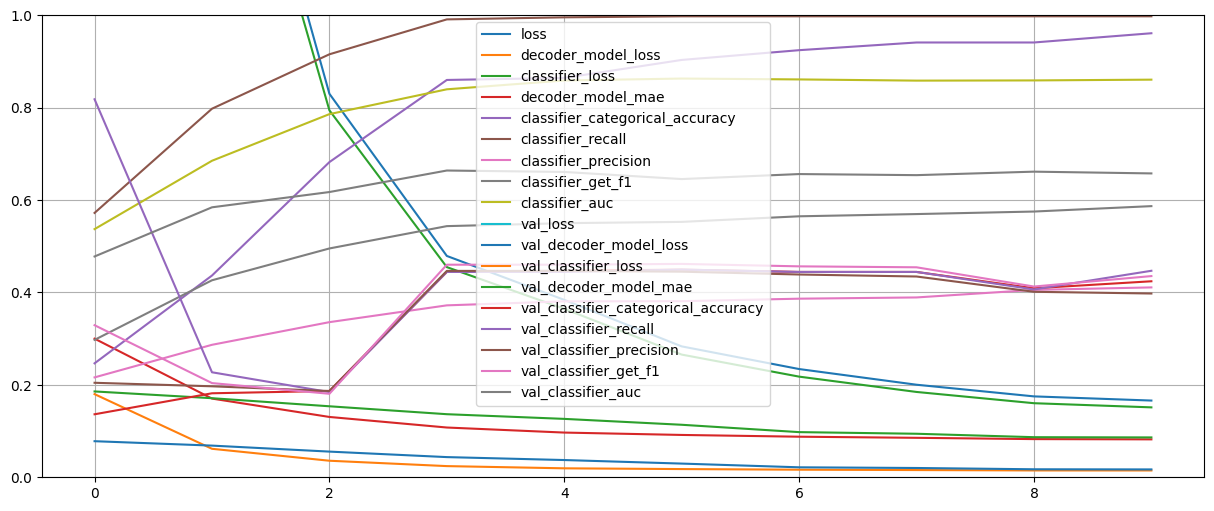

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('Cog_CONV_AE_curves.png')
plt.show()

In [ ]:
os.listdir('/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/train')

['Final AD JPEG',
 'Final CN JPEG',
 'Final EMCI JPEG',
 'Final LMCI JPEG',
 'Final MCI JPEG']

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['AD', 'CN', 'EMCI', 'LMCI', 'MCI'])


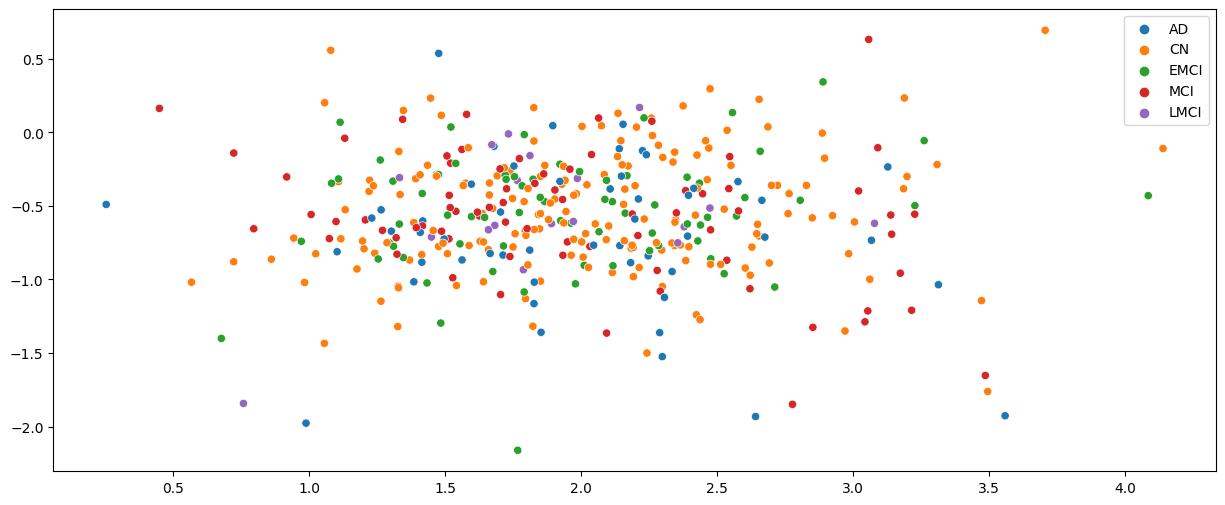

In [ ]:
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('Cog_Conv_AE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

x_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('Conv_AE_TSNE.pdf')

## Variational Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")










import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )


decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(5,activation='sigmoid', name='classifier')(vae.get_layer('encoder_output').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
29/29 [==============================] - 80s 2s/step - loss: 2.5624 - decoder_model_loss: 0.1507 - classifier_loss: 2.4117 - decoder_model_mae: 0.2746 - classifier_categorical_accuracy: 0.2667 - classifier_recall_2: 0.6044 - classifier_precision_2: 0.2054 - classifier_get_f1: 0.2433 - classifier_auc_2: 0.5196 - val_loss: 1.6338 - val_decoder_model_loss: 0.0721 - val_classifier_loss: 1.5617 - val_decoder_model_mae: 0.1764 - val_classifier_categorical_accuracy: 0.3561 - val_classifier_recall_2: 0.5177 - val_classifier_precision_2: 0.2327 - val_classifier_get_f1: 0.3232 - val_classifier_auc_2: 0.5586
Epoch 2/10
29/29 [==============================] - 66s 2s/step - loss: 243052.5469 - decoder_model_loss: 0.0452 - classifier_loss: 243052.5312 - decoder_model_mae: 0.1475 - classifier_categorical_accuracy: 0.6322 - classifier_recall_2: 0.6444 - classifier_precision_2: 0.2449 - classifier_get_f1: 0.3487 - classifier_auc_2: 0.6285 - val_loss: 1.6312 - val_decoder_model_loss: 0.0649 

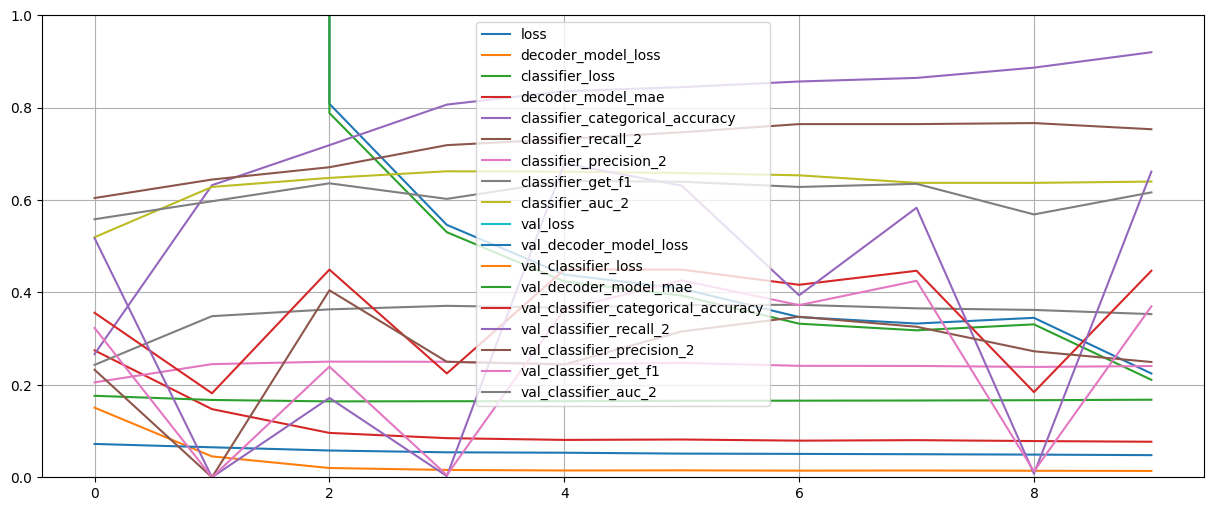

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('cog_VAE_Curves.png')
plt.show()

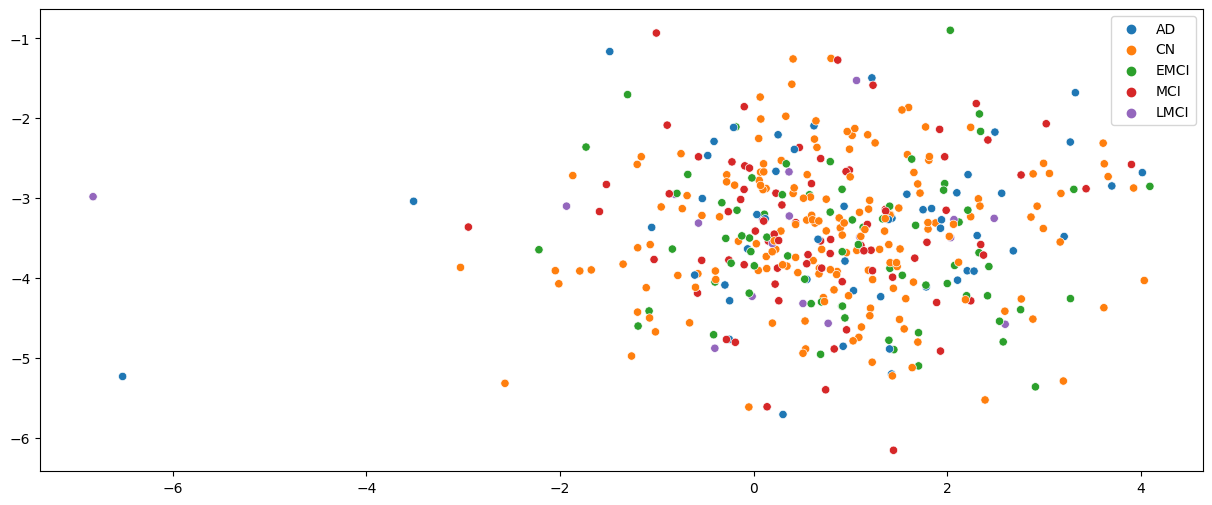

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['AD', 'CN', 'EMCI', 'LMCI', 'MCI'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('cog_VAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

x_test_sampled = x_test[:1000, :]
y_test_sampled = y_test[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(800, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Sparse Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)
encoder_flatten= tensorflow.keras.layers.ActivityRegularization(l1=1e-3, name='reg')(encoder_2)

encoder = tensorflow.keras.models.Model(x, encoder_flatten, name="encoder_model")


import numpy
from tensorflow import keras
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(5,activation='sigmoid', name='classifier')(vae.get_layer('reg').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
29/29 [==============================] - 81s 2s/step - loss: 3.2754 - decoder_model_loss: 0.1689 - classifier_loss: 3.0892 - decoder_model_mae: 0.2845 - classifier_categorical_accuracy: 0.3422 - classifier_recall_4: 0.5644 - classifier_precision_4: 0.2482 - classifier_get_f1: 0.3590 - classifier_auc_4: 0.6071 - val_loss: 1.6305 - val_decoder_model_loss: 0.0718 - val_classifier_loss: 1.5580 - val_decoder_model_mae: 0.1761 - val_classifier_categorical_accuracy: 0.1818 - val_classifier_recall_4: 0.8005 - val_classifier_precision_4: 0.2778 - val_classifier_get_f1: 0.4131 - val_classifier_auc_4: 0.6478
Epoch 2/10
29/29 [==============================] - 61s 2s/step - loss: 1.3283 - decoder_model_loss: 0.0426 - classifier_loss: 1.2696 - decoder_model_mae: 0.1492 - classifier_categorical_accuracy: 0.5500 - classifier_recall_4: 0.8056 - classifier_precision_4: 0.3451 - classifier_get_f1: 0.4888 - classifier_auc_4: 0.8090 - val_loss: 1.5138 - val_decoder_model_loss: 0.0516 - val_clas

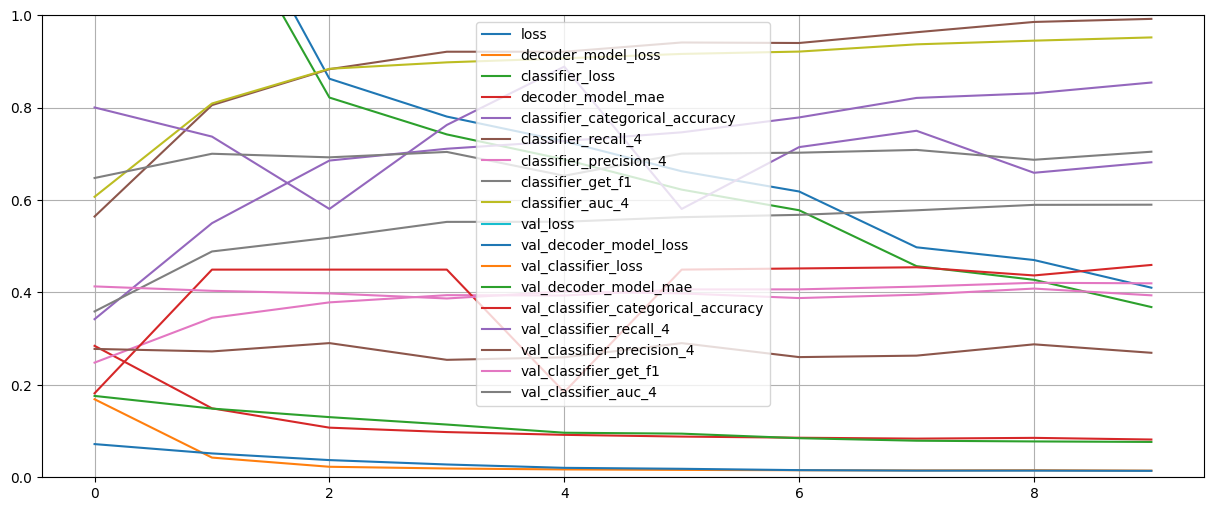

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('cog_SAE_Curves.png')
plt.show()

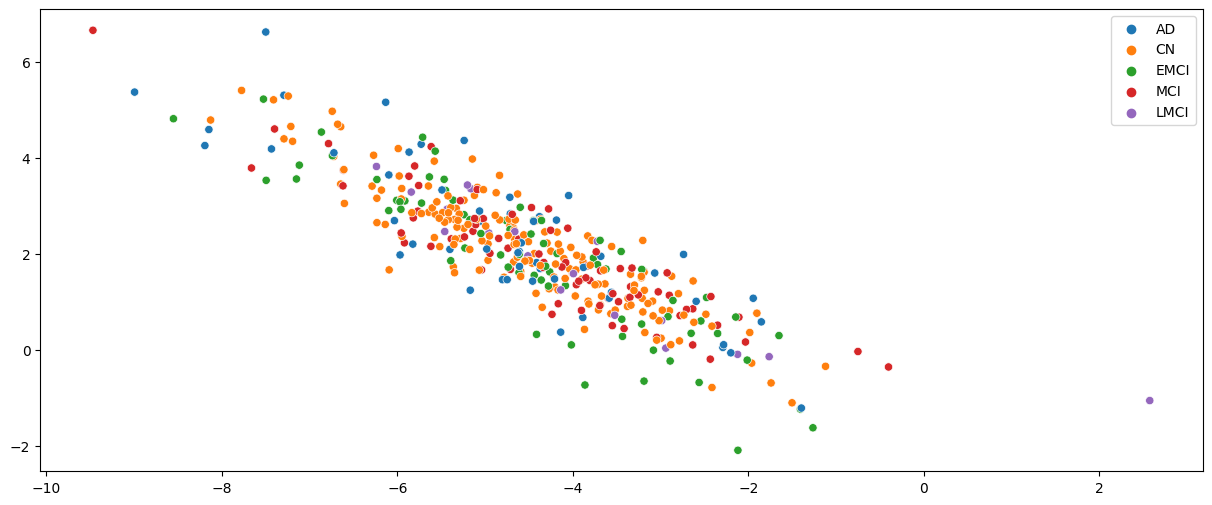

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['AD', 'CN', 'EMCI', 'LMCI', 'MCI'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('cog_SAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test.iloc[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoder.predict(x_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Contractive Autoencoder

In [ ]:
import tensorflow
latent_space_dim=2
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder_1")(encoder_flatten)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder_1)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(4,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

lam=100
def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    W = K.variable(value=encoder.get_layer('encoder_2').get_weights()[0])  
    W = K.transpose(W)
    h = encoder.get_layer('encoder_2').output
    dh = h * (1 - h)
    contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1) #uses the last formula
    return mse + contractive #returns total loss calculated


MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':contractive_loss, 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))


In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig('CAE_Curves.png')
plt.show()

In [ ]:
import seaborn as sns
encoded=encoder(x_test).numpy()
class_names=np.array(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
sns.scatterplot(x=encoded[:,0],y=encoded[:,1], hue=class_names[np.argmax(y_test, axis=1)])
plt.savefig('CAE_Clusters.pdf')
plt.show()

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE

X_test_sampled = x_test[:1000, :]
y_test_sampled = y_test.iloc[:1000]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoder.predict(x_test_sampled).mean(axis = -1).reshape(1000, -1)

# Use TSNE
tsne = TSNE(n_jobs=-1)
X_compressed_2d  =  tsne.fit_transform(x_compressed)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

## Under Autoencoder

In [ ]:
import tensorflow
latent_space_dim=64
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=latent_space_dim*3, name="encoder_1")(encoder_flatten)
encoder__ = tensorflow.keras.layers.Dense(units=latent_space_dim*2, name="encoder__")(encoder_1)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder__)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(5,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
29/29 [==============================] - 64s 2s/step - loss: 20.8877 - decoder_model_loss: 0.1373 - classifier_loss: 20.7504 - decoder_model_mae: 0.2790 - classifier_categorical_accuracy: 0.3044 - classifier_recall_5: 0.7022 - classifier_precision_5: 0.2587 - classifier_get_f1: 0.3772 - classifier_auc_5: 0.6218 - val_loss: 1.5523 - val_decoder_model_loss: 0.0720 - val_classifier_loss: 1.4802 - val_decoder_model_mae: 0.1736 - val_classifier_categorical_accuracy: 0.4495 - val_classifier_recall_5: 0.6869 - val_classifier_precision_5: 0.2351 - val_classifier_get_f1: 0.3530 - val_classifier_auc_5: 0.6599
Epoch 2/10
29/29 [==============================] - 45s 2s/step - loss: 1.1103 - decoder_model_loss: 0.0502 - classifier_loss: 1.0600 - decoder_model_mae: 0.1600 - classifier_categorical_accuracy: 0.7278 - classifier_recall_5: 0.9700 - classifier_precision_5: 0.3346 - classifier_get_f1: 0.4982 - classifier_auc_5: 0.8785 - val_loss: 1.7461 - val_decoder_model_loss: 0.0542 - val_cl

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
encoded=encoder(x_test).numpy()
x_test_sampled = x_test[:, :]
y_test_sampled = y_test[:]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(396, -1)


In [ ]:
# Use TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(encoded)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('Cog_Under_AE_TSNE.pdf')

## Overcomplete Autoencoder

In [ ]:
import tensorflow
latent_space_dim=128
img_size = 128
num_channels = 3
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_1 = tensorflow.keras.layers.Dense(units=32, name="encoder_1")(encoder_flatten)
encoder__ = tensorflow.keras.layers.Dense(units=64, name="encoder__")(encoder_1)
encoder_2 = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_2")(encoder__)

encoder = tensorflow.keras.models.Model(x, encoder_2, name="encoder_model")


import numpy
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)
decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tensorflow.keras.models.Model([decoder_input], [decoder_output], name="decoder_model")
# vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
# vae_encoder_output = encoder(vae_input)
# vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model([encoder.input], decoder(encoder.output), name="VAE")

classifier = keras.layers.Dense(5,activation='sigmoid', name='classifier')(vae.get_layer('encoder_2').output)

MODEL= tensorflow.keras.models.Model([vae.input], [vae.output, classifier], name="VAE")


import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

MODEL.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss={'decoder_model':'mse', 'classifier':'categorical_crossentropy'},
            metrics={'decoder_model':['mae'], 'classifier':[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1,keras.metrics.AUC()]})
history=MODEL.fit(x_train,[x_train, y_train], epochs=10, batch_size=32, shuffle=True, validation_data=(x_test,[x_test, y_test]))

Epoch 1/10
29/29 [==============================] - 56s 2s/step - loss: 8.3474 - decoder_model_loss: 0.1451 - classifier_loss: 8.2023 - decoder_model_mae: 0.2832 - classifier_categorical_accuracy: 0.2944 - classifier_recall: 0.8267 - classifier_precision: 0.2422 - classifier_get_f1: 0.3677 - classifier_auc: 0.6093 - val_loss: 1.6498 - val_decoder_model_loss: 0.0737 - val_classifier_loss: 1.5761 - val_decoder_model_mae: 0.1768 - val_classifier_categorical_accuracy: 0.1894 - val_classifier_recall: 0.9268 - val_classifier_precision: 0.2400 - val_classifier_get_f1: 0.3809 - val_classifier_auc: 0.6391
Epoch 2/10
29/29 [==============================] - 49s 2s/step - loss: 1.3234 - decoder_model_loss: 0.0494 - classifier_loss: 1.2741 - decoder_model_mae: 0.1559 - classifier_categorical_accuracy: 0.5322 - classifier_recall: 0.8689 - classifier_precision: 0.3044 - classifier_get_f1: 0.4618 - classifier_auc: 0.7631 - val_loss: 1.6052 - val_decoder_model_loss: 0.0567 - val_classifier_loss: 1.548

In [ ]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
encoded=encoder(x_test).numpy()
x_test_sampled = x_test[:, :]
y_test_sampled = y_test[:]
# Visualizing the Latent representation - Taking the average of the volume
x_compressed = encoded.mean(axis = -1).reshape(396, -1)


In [ ]:
# Use TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
x_compressed_2d  =  tsne.fit_transform(encoded)

plt.figure(figsize = (12, 7))
cmap = plt.get_cmap('RdBu', 10)
sc = plt.scatter(x_compressed_2d[:, 0], x_compressed_2d[:, 1], c = y_test_sampled, alpha = .85, cmap = cmap)
cax = plt.colorbar(sc, ticks=np.arange(0,10))
plt.xlabel('tsne 1')
plt.ylabel('tsne 2')
plt.savefig('cog_Over_AE_TSNE.pdf')